<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to access CERN Accelerator logging service data__.

### Connect to the cluster (NXCals)
In the SWAN configuration menu:
- Choose the NXCals project software stack
- Choose the NXCals Hadoop cluster

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready
* SELECT NXCALS configuration bundle
* Access to the cluster and NXCALS data is controlled by acc-logging-team, please write to acc-logging-team@cern.ch


# NXCals DataExtraction API - Examples
See NXCals API documentation at - http://nxcals-docs.web.cern.ch/current/

## 1) Extract data using device/property pairs

In [1]:
# source the nxcals python libs
from cern.nxcals.api.extraction.data.builders import *
from cern.nxcals.pyquery.builders import *

# build the query and load data into spark dataframe
df1 = DevicePropertyQuery \
            .builder(spark) \
            .system("CMW") \
            .startTime("2022-11-01 00:00:00.000") \
            .endTime("2022-11-02 00:00:00.000") \
            .entity() \
            .parameter("RADMON.PS-10/ExpertMonitoringAcquisition") \
            .buildDataset()

### Inspect data

In [2]:
df1.printSchema()

root
 |-- PinDiodeVoltageOutOfRange: boolean (nullable = true)
 |-- Radfet1VoltageOutOfRange: boolean (nullable = true)
 |-- Radfet2VoltageOutOfRange: boolean (nullable = true)
 |-- __record_timestamp__: long (nullable = true)
 |-- __record_version__: long (nullable = true)
 |-- acqStamp: long (nullable = true)
 |-- class: string (nullable = true)
 |-- current_18V: double (nullable = true)
 |-- current_8V5: double (nullable = true)
 |-- current_memBanks: double (nullable = true)
 |-- current_radfet: double (nullable = true)
 |-- cyclestamp: long (nullable = true)
 |-- device: string (nullable = true)
 |-- property: string (nullable = true)
 |-- pt100Value: double (nullable = true)
 |-- selector: string (nullable = true)
 |-- temperatureDeported: double (nullable = true)
 |-- temperatureSensorBoard: double (nullable = true)
 |-- voltage_18V: double (nullable = true)
 |-- voltage_3V3: double (nullable = true)
 |-- voltage_3VNeg: double (nullable = true)
 |-- voltage_5V: double (nullable 

In [3]:
df1.select('acqStamp','voltage_18V','current_18V','device','pt100Value').show()

+-------------------+------------------+------------------+------------+------------------+
|           acqStamp|       voltage_18V|       current_18V|      device|        pt100Value|
+-------------------+------------------+------------------+------------+------------------+
|1667260801078283000|              null|              null|RADMON.PS-10|       109.4169887|
|1667260802078290000|              null| 44.00730505585671|RADMON.PS-10|109.29791806000001|
|1667260803078315000| 20.02644650638104|44.098701328039176|RADMON.PS-10|109.08954444000001|
|1667260805078360000| 20.02644650638104|     44.1291667521|RADMON.PS-10|108.70256486000001|
|1667260807078387000|20.024923235177997|44.464286416769035|RADMON.PS-10|      109.49140785|
|1667260808078408000|              null| 44.02253776788712|RADMON.PS-10|      108.77698401|
|1667260809078413000|              null| 44.40335556864739|RADMON.PS-10|      108.76210018|
|1667260811078467000|20.024923235177997| 44.38812285661698|RADMON.PS-10|        

### Register the dataFrame as temporary table (myData) to write direct SQL queries.

In [4]:
df1.createOrReplaceTempView("myData")

In [5]:
# a simple select with min / max
spark.sql("select  min(acqStamp), max(acqStamp) from myData").show()

+-------------------+-------------------+
|      min(acqStamp)|      max(acqStamp)|
+-------------------+-------------------+
|1667260800078284000|1667347199568841000|
+-------------------+-------------------+



In [6]:
# some aggregation...
spark.sql("select device, count(*) from myData group by device").show()

+------------+--------+
|      device|count(1)|
+------------+--------+
|RADMON.PS-10|   86399|
+------------+--------+



### Draw a plot using matplotlib

In [7]:
# Select the data columns of interest
# fetch data into a Pandas dataframe for visualization
import pandas as pd

p_df = df1.select('acqStamp','current_18V').filter("current_18V is not null").toPandas()


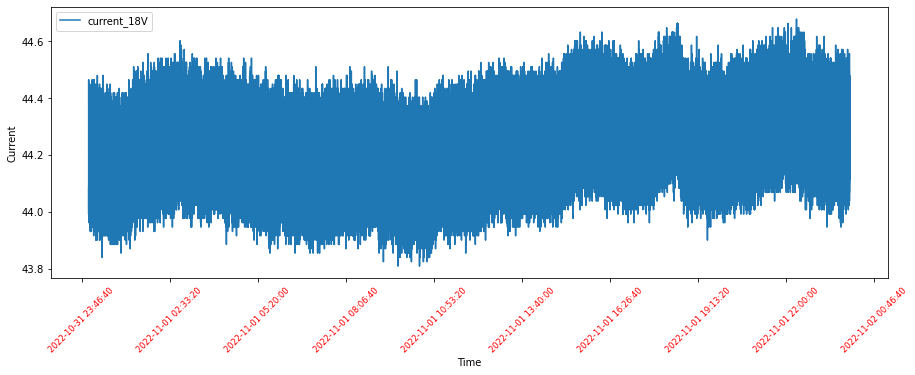

In [8]:
import matplotlib
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline

data = p_df.sort_values(by='acqStamp')

def format_fn(tick_val, tick_pos):
        return pd.to_datetime(tick_val,unit='ns')

myplot=data.plot(x='acqStamp',y='current_18V', figsize=(15,5))
myplot.set_xlabel('Time')
myplot.set_ylabel('Current')

myplot.xaxis.set_major_formatter(FuncFormatter(format_fn))
myplot.xaxis.set_major_locator(MaxNLocator(integer=True))
myplot.tick_params(axis='x', which='major', labelsize='small', labelcolor='r', rotation=45)


## 2) Read TGM data

In [9]:
tgmData = DevicePropertyQuery \
                .builder(spark) \
                .system("CMW") \
                .startTime("2022-11-01 00:00:00.000") \
                .endTime("2022-11-02 00:00:00.000") \
                .entity() \
                .device("CPS.TGM") \
                .property("FULL-TELEGRAM.STRC") \
                .buildDataset()

In [10]:
tgmData.toPandas()[:2]

,BATCH,BEAMID,BPNM,COMLN,CYCLE,CYTAG,DEST,DEST2,DURN,FREE14,...,USER,__record_timestamp__,__record_version__,acqStamp,class,cyclestamp,device,property,selector,nxcals_entity_id
0,0,57090,64,None,48,NaN,PS_DUMP,NONE,1,NaN,...,ZERO,1667260813900000000,0,1667260813850000000,CPS.TGM,1667260813900000000,CPS.TGM,FULL-TELEGRAM.STRC,CPS.USER.ALL,46955
1,0,16555,25,None,22,NaN,NTOF,NONE,1,NaN,...,TOF,1667260848700000000,0,1667260848650000000,CPS.TGM,1667260848700000000,CPS.TGM,FULL-TELEGRAM.STRC,CPS.USER.ALL,46955


In [11]:
# Aggregate and count per user
tgmData.groupBy("USER").count().show()

+--------+-----+
|    USER|count|
+--------+-----+
|     MD4|  263|
| LHCIND2|  212|
|   EAST1| 4205|
|      AD|  746|
|    LHC5|   70|
|     MD6|  276|
|LHCPILOT|   64|
|    ION3| 1095|
|    ZERO|15940|
| SFTPRO3| 3473|
|    ION1| 2168|
|   EAST3| 6691|
|     MD2|  297|
|    LHC3| 1205|
|    MD10|   93|
| SFTPRO1| 1364|
|     TOF|13072|
|     MD5|  117|
| SFTPRO2| 1921|
+--------+-----+



In [12]:
spark.stop()